# 224x224 Retina Fotoğraflarından Diyabetik Retinopati Tespiti ve Sınıflandırma projesi

# Diabetic Retinopathy Detection and Classification Project from 224x224 Retinal Photos

*İsmail DUMLU 240711003* \
*M. Mirza ERDEM 240711012* \
*M Selçuk İNCİ 240711020*

In [119]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sovitrath/diabetic-retinopathy-224x224-2019-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'diabetic-retinopathy-224x224-2019-data' dataset.
Path to dataset files: /kaggle/input/diabetic-retinopathy-224x224-2019-data


In [120]:
!ls -l {path}

total 56
drwxr-sr-x 7 1000 1000     0 Dec 16 20:11 colored_images
-rw-r--r-- 1 1000 1000 54948 Dec 16 20:11 train.csv


In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [122]:
df = pd.read_csv("/kaggle/input/diabetic-retinopathy-224x224-2019-data/train.csv")

df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [123]:
import cv2

In [124]:
from tensorflow.keras.applications.efficientnet import preprocess_input
def crop_image_from_gray(img, tol=7):
    # Eğer görüntü grayscale ise
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]

    # Eğer görüntü RGB ise
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        # Eğer tamamen siyahsa kırpma yapma
        if img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0] == 0:
            return img

        # Kanalları ayrı ayrı kırp
        img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
        img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
        img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]

        return np.stack([img1, img2, img3], axis=-1)

def preprocess_image(image):
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = preprocess_input(image.astype(np.float32))
    return image


In [125]:
from sklearn.model_selection import train_test_split
x = df['id_code']
y = df['diagnosis']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42, stratify=y)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [126]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [127]:
!ls -l {data_dir}

total 0
drwxr-sr-x 2 1000 1000 0 Dec 16 20:11 Mild
drwxr-sr-x 2 1000 1000 0 Dec 16 20:11 Moderate
drwxr-sr-x 2 1000 1000 0 Dec 16 20:11 No_DR
drwxr-sr-x 2 1000 1000 0 Dec 16 20:11 Proliferate_DR
drwxr-sr-x 2 1000 1000 0 Dec 16 20:11 Severe


In [128]:
diagnosis_map = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR'
}
print(diagnosis_map)

{0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferate_DR'}


In [129]:
image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

)

validation_datagen = ImageDataGenerator(
    rescale=None, # Explicitly set to None
    preprocessing_function=preprocess_image
    )

In [130]:
train_df = pd.DataFrame({'id_code': x_train, 'diagnosis': y_train})
val_df = pd.DataFrame({'id_code': x_test, 'diagnosis': y_test})

train_df['folder_name'] = train_df['diagnosis'].map(diagnosis_map)
val_df['folder_name'] = val_df['diagnosis'].map(diagnosis_map)

# 'diagnosis' sütununu string'e dönüştürme satırlarını kaldırıyoruz, böylece integer kalır.
# train_df['diagnosis'] = train_df['diagnosis'].astype(str)
# val_df['diagnosis'] = val_df['diagnosis'].astype(str)

train_df['id_code'] = train_df['folder_name'] + '/' + train_df['id_code'] + '.png'
val_df['id_code'] = val_df['folder_name'] + '/' + val_df['id_code'] + '.png'

display(train_df.head())
display(val_df.head())

,id_code,diagnosis,folder_name
2579,No_DR/b2b79b37d314.png,0,No_DR
309,Moderate/175dd560810a.png,2,Moderate
2826,Severe/c3cd0200df79.png,3,Severe
2989,No_DR/cfed7c1172ec.png,0,No_DR
3344,Moderate/e811f39a1243.png,2,Moderate


,id_code,diagnosis,folder_name
1595,No_DR/6fe67fd7f5d1.png,0,No_DR
3449,No_DR/ef8c39eb9157.png,0,No_DR
1394,Proliferate_DR/61bbc11fe503.png,4,Proliferate_DR
1379,No_DR/60edda7b4871.png,0,No_DR
3043,No_DR/d30d079e6f9a.png,0,No_DR


In [131]:
from numpy.random import shuffle
data_dir = path + '/colored_images'
img_size = image_size[0]

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=data_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='raw' # 'categorical' yerine 'raw' kullanıyoruz
)

validation_generator = validation_datagen.flow_from_dataframe(
    val_df,
    directory=data_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False # 'categorical' yerine 'raw' kullanıyoruz
)

class_names = list(diagnosis_map.values())
print("Classes:", class_names)

Found 2929 validated image filenames.
Found 733 validated image filenames.
Classes: ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


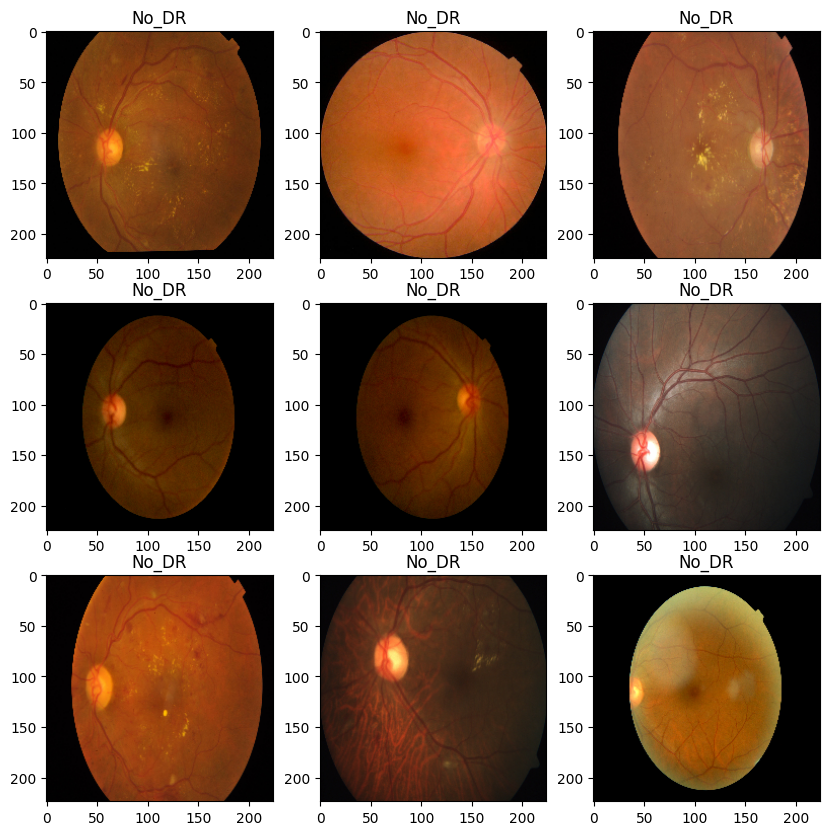

In [132]:
images, labels = next(train_generator)


plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    label_index = np.argmax(labels[i]) # Düzeltilen kısım: one-hot encoded etiketten indeksi al
    plt.title(class_names[label_index])

    plt.imshow(images[i]/255)


plt.show()

In [133]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

In [134]:
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)

)

In [135]:
from sklearn.utils import class_weight

# 1. Ağırlıkları Hesapla
# 'balanced' modu, az olan sınıfa otomatik olarak yüksek puan verir.
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train), # Sınıfları bul (0, 1, 2, 3, 4)
    y=y_train                   # Eğitim verisindeki dağılıma bak
)

# 2. Sözlük Formatına Çevir (Keras bu formatı ister)
class_weights = dict(enumerate(weights))

# Kontrol için ekrana yazdır
print("Hesaplanan Sınıf Ağırlıkları:", class_weights)

Hesaplanan Sınıf Ağırlıkları: {0: np.float64(0.4056786703601108), 1: np.float64(1.979054054054054), 2: np.float64(0.7331664580725907), 3: np.float64(3.803896103896104), 4: np.float64(2.4822033898305085)}


In [136]:
# Ustanın (EfficientNet) bilgilerini kilitliyoruz
base_model.trainable = False

# Kendi katmanlarını ekle (Çırak)
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

In [137]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_10        │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_5     │ (None, 224, 224,  │          7 │ rescaling_10[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_11        │ (None, 224, 224,  │          0 │ normalization_5[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_11[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,378,792 (16.70 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [138]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# ==========================================
# Sadece senin eklediğin katmanlar hızlıca eğitilir
# ==========================================
print("\n--- 1. AŞAMA: ISINMA TURU BAŞLIYOR (Sadece son katmanlar) ---")

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), # label_smoothing kaldırıldı
    metrics=[
        'accuracy'
        # tf.keras.metrics.AUC(name='auc') # Temporarily removed to fix the error
    ]
)



# Kısa bir eğitim (3-5 Epoch yeterli)
history_warmup = model.fit(
    train_generator,
    epochs=6,
    validation_data=validation_generator,
    class_weight=class_weights, # Sınıf ağırlıkları
    verbose=1
)



# Kilidi açıp tüm modeli yavaşça eğitiyoruz
# ==========================================
print("\n--- 2. AŞAMA: İNCE AYAR BAŞLIYOR (Tüm Model) ---")

for layer in base_model.layers[:-30]:
    layer.trainable = False

for layer in base_model.layers[-30:]:
    layer.trainable = True


model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), # label_smoothing kaldırıldı
    metrics=[
        'accuracy'
        # tf.keras.metrics.AUC(name='auc') # Temporarily removed to fix the error
    ]
)




# Callbacks tanımları (2. aşama için kritik)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_diabetic_model.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)

# Asıl uzun eğitim
history_finetune = model.fit(
    train_generator,
    epochs=100, # Burayı istersen 20 yapabilirsin
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)


--- 1. AŞAMA: ISINMA TURU BAŞLIYOR (Sadece son katmanlar) ---
Epoch 1/6


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 370ms/step - accuracy: 0.3392 - loss: 1.5902 - val_accuracy: 0.5675 - val_loss: 1.1189
Epoch 2/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.5713 - loss: 1.3104 - val_accuracy: 0.6521 - val_loss: 0.9673
Epoch 3/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.6391 - loss: 1.1799 - val_accuracy: 0.6726 - val_loss: 0.8902
Epoch 4/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.6744 - loss: 1.0792 - val_accuracy: 0.6739 - val_loss: 0.8706
Epoch 5/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.6816 - loss: 1.0750 - val_accuracy: 0.7217 - val_loss: 0.8018
Epoch 6/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.6850 - loss: 1.0692 - val_accuracy: 0.7149 - val_loss: 0.7824

--- 2. AŞAMA: İNCE AYAR BAŞLIYOR (Tüm Model) ---
Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.5604 - loss: 1.1209

92/92 ━━━━━━━━━━━━━━━━━━━━ 66s 411ms/step - accuracy: 0.5608 - loss: 1.1201 - val_accuracy: 0.6767 - val_loss: 0.8050 - learning_rate: 1.0000e-05
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6834 - loss: 0.8869

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.6834 - loss: 0.8866 - val_accuracy: 0.7162 - val_loss: 0.7930 - learning_rate: 1.0000e-05
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7321 - loss: 0.7810

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.7321 - loss: 0.7808 - val_accuracy: 0.7462 - val_loss: 0.7665 - learning_rate: 1.0000e-05
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7349 - loss: 0.7421

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.7350 - loss: 0.7419 - val_accuracy: 0.7503 - val_loss: 0.7397 - learning_rate: 1.0000e-05
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7500 - loss: 0.6810

92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.7501 - loss: 0.6810 - val_accuracy: 0.7531 - val_loss: 0.7149 - learning_rate: 1.0000e-05
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7484 - loss: 0.6813

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.7486 - loss: 0.6810 - val_accuracy: 0.7517 - val_loss: 0.6954 - learning_rate: 1.0000e-05
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7758 - loss: 0.6387

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.7758 - loss: 0.6387 - val_accuracy: 0.7558 - val_loss: 0.6798 - learning_rate: 1.0000e-05
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7658 - loss: 0.6273

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.7659 - loss: 0.6272 - val_accuracy: 0.7585 - val_loss: 0.6651 - learning_rate: 1.0000e-05
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7652 - loss: 0.6222

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.7654 - loss: 0.6220 - val_accuracy: 0.7626 - val_loss: 0.6542 - learning_rate: 1.0000e-05
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7798 - loss: 0.5934

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.7798 - loss: 0.5935 - val_accuracy: 0.7640 - val_loss: 0.6451 - learning_rate: 1.0000e-05
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7738 - loss: 0.5943

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.7739 - loss: 0.5942 - val_accuracy: 0.7667 - val_loss: 0.6372 - learning_rate: 1.0000e-05
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8116 - loss: 0.5298

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.8114 - loss: 0.5302 - val_accuracy: 0.7681 - val_loss: 0.6320 - learning_rate: 1.0000e-05
Epoch 13/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7950 - loss: 0.5480

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.7950 - loss: 0.5481 - val_accuracy: 0.7763 - val_loss: 0.6278 - learning_rate: 1.0000e-05
Epoch 14/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8033 - loss: 0.5402

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.8034 - loss: 0.5403 - val_accuracy: 0.7735 - val_loss: 0.6227 - learning_rate: 1.0000e-05
Epoch 15/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8045 - loss: 0.5280

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.8044 - loss: 0.5281 - val_accuracy: 0.7804 - val_loss: 0.6157 - learning_rate: 1.0000e-05
Epoch 16/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7922 - loss: 0.5480

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.7924 - loss: 0.5478 - val_accuracy: 0.7790 - val_loss: 0.6114 - learning_rate: 1.0000e-05
Epoch 17/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8044 - loss: 0.5397

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.8045 - loss: 0.5394 - val_accuracy: 0.7817 - val_loss: 0.6075 - learning_rate: 1.0000e-05
Epoch 18/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8183 - loss: 0.5019

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.8183 - loss: 0.5018 - val_accuracy: 0.7763 - val_loss: 0.6049 - learning_rate: 1.0000e-05
Epoch 19/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8081 - loss: 0.5202

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.8082 - loss: 0.5201 - val_accuracy: 0.7804 - val_loss: 0.6009 - learning_rate: 1.0000e-05
Epoch 20/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8252 - loss: 0.5021

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.8252 - loss: 0.5020 - val_accuracy: 0.7831 - val_loss: 0.5979 - learning_rate: 1.0000e-05
Epoch 21/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8235 - loss: 0.4822

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.8235 - loss: 0.4824 - val_accuracy: 0.7858 - val_loss: 0.5952 - learning_rate: 1.0000e-05
Epoch 22/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8397 - loss: 0.4535

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.8396 - loss: 0.4537 - val_accuracy: 0.7899 - val_loss: 0.5920 - learning_rate: 1.0000e-05
Epoch 23/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8172 - loss: 0.4794

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.8174 - loss: 0.4793 - val_accuracy: 0.7804 - val_loss: 0.5918 - learning_rate: 1.0000e-05
Epoch 24/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8399 - loss: 0.4533

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.8399 - loss: 0.4535 - val_accuracy: 0.7831 - val_loss: 0.5889 - learning_rate: 1.0000e-05
Epoch 25/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8329 - loss: 0.4605

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.8328 - loss: 0.4607 - val_accuracy: 0.7885 - val_loss: 0.5869 - learning_rate: 1.0000e-05
Epoch 26/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8237 - loss: 0.4719

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.8238 - loss: 0.4718 - val_accuracy: 0.7913 - val_loss: 0.5855 - learning_rate: 1.0000e-05
Epoch 27/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8288 - loss: 0.4528

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.8289 - loss: 0.4527 - val_accuracy: 0.7967 - val_loss: 0.5834 - learning_rate: 1.0000e-05
Epoch 28/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8327 - loss: 0.4666

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.8328 - loss: 0.4664 - val_accuracy: 0.7954 - val_loss: 0.5815 - learning_rate: 1.0000e-05
Epoch 29/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8371 - loss: 0.4262

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.8371 - loss: 0.4263 - val_accuracy: 0.7940 - val_loss: 0.5802 - learning_rate: 1.0000e-05
Epoch 30/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8434 - loss: 0.4401

92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.8434 - loss: 0.4401 - val_accuracy: 0.7954 - val_loss: 0.5781 - learning_rate: 1.0000e-05
Epoch 31/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8460 - loss: 0.4200

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.8460 - loss: 0.4201 - val_accuracy: 0.7926 - val_loss: 0.5777 - learning_rate: 1.0000e-05
Epoch 32/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8602 - loss: 0.4073

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.8600 - loss: 0.4075 - val_accuracy: 0.7940 - val_loss: 0.5752 - learning_rate: 1.0000e-05
Epoch 33/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8562 - loss: 0.4014

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.8562 - loss: 0.4015 - val_accuracy: 0.7954 - val_loss: 0.5738 - learning_rate: 1.0000e-05
Epoch 34/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.8535 - loss: 0.3924 - val_accuracy: 0.7954 - val_loss: 0.5751 - learning_rate: 1.0000e-05
Epoch 35/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8359 - loss: 0.4376

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.8361 - loss: 0.4374 - val_accuracy: 0.7940 - val_loss: 0.5734 - learning_rate: 1.0000e-05
Epoch 36/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8593 - loss: 0.3868

92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.8592 - loss: 0.3869 - val_accuracy: 0.7913 - val_loss: 0.5717 - learning_rate: 1.0000e-05
Epoch 37/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.8518 - loss: 0.3956 - val_accuracy: 0.7872 - val_loss: 0.5720 - learning_rate: 1.0000e-05
Epoch 38/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8590 - loss: 0.3897
Epoch 38: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.8590 - loss: 0.3898 - val_accuracy: 0.7926 - val_loss: 0.5718 - learning_rate: 1.0000e-05
Epoch 39/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.8557 - loss: 0.3800 - val_accuracy: 0.7926 - val_loss: 0.5718 - learning_rate: 5.0000e-06
Epoch 40/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8656 - loss: 0.3768
Epoch 40: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.8656 -

In [139]:
model.save("team2_diabeticRetinopathy.keras")

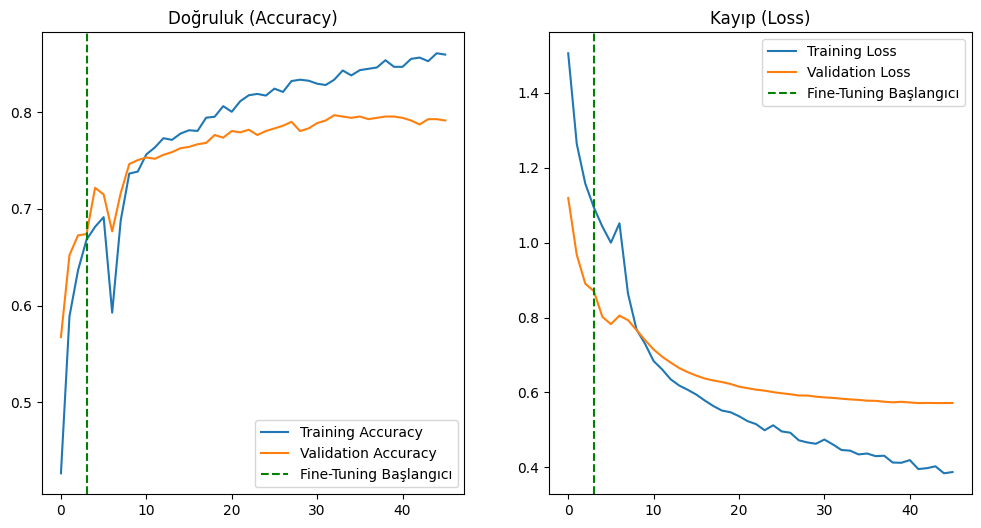

In [140]:
# ==========================================
# 4. ADIM: SONUÇLARI BİRLEŞTİRME VE ÇİZME
# ==========================================
# İki aşamanın grafik verilerini birleştiriyoruz ki tek grafikte görelim
acc = history_warmup.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history_warmup.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history_warmup.history['loss'] + history_finetune.history['loss']
val_loss = history_warmup.history['val_loss'] + history_finetune.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# Geçiş noktasını çizgiyle gösterelim
plt.axvline(x=3, color='g', linestyle='--', label='Fine-Tuning Başlangıcı')
plt.title('Doğruluk (Accuracy)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=3, color='g', linestyle='--', label='Fine-Tuning Başlangıcı')
plt.title('Kayıp (Loss)')
plt.legend()
plt.show()

In [141]:
print("LR:", float(model.optimizer.learning_rate.numpy()))
print("Loss:", model.loss)
print("Trainable layers:", sum(l.trainable for l in model.layers))
print("Class mode:", getattr(train_generator, "class_mode", None))


LR: 2.499999936844688e-06
Loss: <LossFunctionWrapper(<function sparse_categorical_crossentropy at 0x783fee14fec0>, kwargs={'from_logits': False, 'ignore_class': None, 'axis': -1})>
Trainable layers: 34
Class mode: raw


In [142]:
validation_generator.reset()
pred = model.predict(validation_generator, verbose=0)
y_pred = np.argmax(pred, axis=1)

print("pred len:", len(y_pred))
print("y_test len:", len(y_test.values))
print("val shuffle:", getattr(validation_generator, "shuffle", None))
print("pred class counts:", np.bincount(y_pred))


pred len: 733
y_test len: 733
val shuffle: False
pred class counts: [363  69 241  20  40]


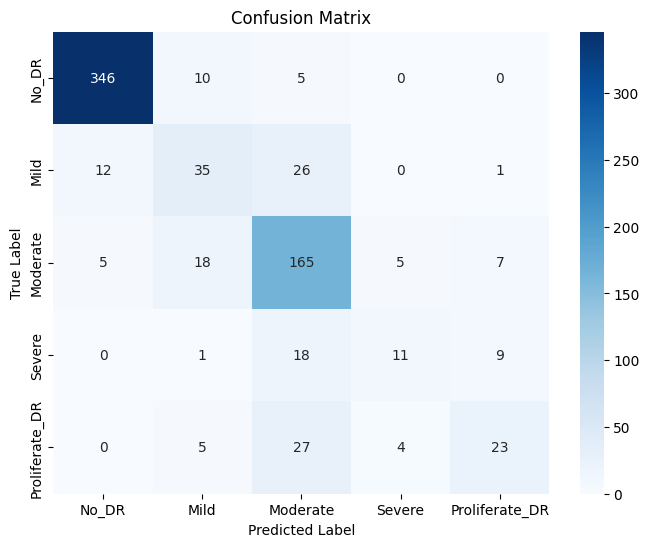

In [143]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [144]:
from sklearn.metrics import cohen_kappa_score
import numpy as np

predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = y_test.values[:len(predicted_classes)]

kappa_score = cohen_kappa_score(
    true_classes,
    predicted_classes,
    weights="quadratic"
)

print(f"Quadratic Cohen's Kappa: {kappa_score:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step
Quadratic Cohen's Kappa: 0.8528
